In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

from datetime import datetime
import os
import glob
from functools import reduce

# A. Mô hình hóa bài toán

In [2]:
base_dir = os.getcwd()

# Nhảy lên 1 cấp để tới project/
project_dir = os.path.dirname(base_dir)

# Ghép tới thư mục data
data_dir = os.path.join(project_dir, "data/gold")

# Ghép tới file CSV
file_path = os.path.join(data_dir, "gold_df_s2.csv")

# Tải dữ liệu đã làm sạch từ file CSV
try:
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    print("Tải và xử lý dữ liệu gốc thành công.")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file 'gold_df_s2.csv'. Vui lòng đặt file này cùng thư mục với mã nguồn.")
    exit()

Tải và xử lý dữ liệu gốc thành công.


In [3]:
df.head()

,close_PRICE_CS_1D,volume_PRICE_CS_1D,close_SP_500_1D,volume_SP_500_1D,close_CDS_5Y_CS_1D,close_CBOE_Volatility_Index_FRED,close_SX7E_STOXX_Banks_EUR_Price,Provision for credit losses_Internal_Data_Financial_Report,Non-accrual loans / Gross loans_Internal_Data_Financial_Report,Gross impaired loans / Gross loans_Internal_Data_Financial_Report,...,Return on Equity (ROE)_Internal_Data_Financial_Report,close_ECONOMICS_USGDPCP_1D,close_ECONOMICS_USCPI_1D,close_ECONOMICS_EUGDPCP_1D,close_ECONOMICS_EUCPI_1D,close_ECONOMICS_CHGDPCP_1D,close_ECONOMICS_CHCPI_1D,close_FED_FUNDS,close_ECB_INTEREST_RATE_FRED,total_mark_scenario_02_nlp
time,,,,,,,,,,,,,,,,,,,,,
2020-10-01,9.91,1629038.0,3380.80,2.355862e+09,57.69,26.70,53.99,94.0,0.008,0.012,...,0.048,2.051178e+13,260.28,2.768364e+12,104.96,1.783929e+11,100.34,0.09,0.0,0.0
2020-10-02,10.07,2478219.0,3348.44,2.350091e+09,56.20,27.63,54.15,94.0,0.008,0.012,...,0.048,2.051178e+13,260.28,2.768364e+12,104.96,1.783929e+11,100.34,0.09,0.0,0.0
2020-10-03,10.07,2478219.0,3348.44,2.350091e+09,56.20,27.63,54.15,94.0,0.008,0.012,...,0.048,2.051178e+13,260.28,2.768364e+12,104.96,1.783929e+11,100.34,0.09,0.0,0.0
2020-10-04,10.07,2478219.0,3348.44,2.350091e+09,56.20,27.63,54.15,94.0,0.008,0.012,...,0.048,2.051178e+13,260.28,2.768364e+12,104.96,1.783929e+11,100.34,0.09,0.0,0.0
2020-10-05,10.32,2244035.0,3408.63,2.040148e+09,54.94,27.96,55.31,94.0,0.008,0.012,...,0.048,2.051178e+13,260.28,2.768364e+12,104.96,1.783929e+11,100.34,0.09,0.0,0.0


In [4]:
df.tail()

,close_PRICE_CS_1D,volume_PRICE_CS_1D,close_SP_500_1D,volume_SP_500_1D,close_CDS_5Y_CS_1D,close_CBOE_Volatility_Index_FRED,close_SX7E_STOXX_Banks_EUR_Price,Provision for credit losses_Internal_Data_Financial_Report,Non-accrual loans / Gross loans_Internal_Data_Financial_Report,Gross impaired loans / Gross loans_Internal_Data_Financial_Report,...,Return on Equity (ROE)_Internal_Data_Financial_Report,close_ECONOMICS_USGDPCP_1D,close_ECONOMICS_USCPI_1D,close_ECONOMICS_EUGDPCP_1D,close_ECONOMICS_EUCPI_1D,close_ECONOMICS_CHGDPCP_1D,close_ECONOMICS_CHCPI_1D,close_FED_FUNDS,close_ECB_INTEREST_RATE_FRED,total_mark_scenario_02_nlp
time,,,,,,,,,,,,,,,,,,,,,
2023-06-26,0.8858,63950993.0,4328.81,2.224000e+09,101.49,14.25,102.54,83.0,0.008,0.012,...,1.094,2.211230e+13,304.127,2.992972e+12,123.15,1.915362e+11,106.25,5.08,4.0,-8.3
2023-06-27,0.8858,63950993.0,4378.40,2.254000e+09,101.48,13.74,103.88,83.0,0.008,0.012,...,1.094,2.211230e+13,304.127,2.992972e+12,123.15,1.915362e+11,106.25,5.08,4.0,0.0
2023-06-28,0.8858,63950993.0,4376.85,2.245000e+09,100.99,13.43,104.59,83.0,0.008,0.012,...,1.094,2.211230e+13,304.127,2.992972e+12,123.15,1.915362e+11,106.25,5.08,4.0,0.0
2023-06-29,0.8858,63950993.0,4396.45,2.127000e+09,100.00,13.54,106.12,83.0,0.008,0.012,...,1.094,2.211230e+13,304.127,2.992972e+12,123.15,1.915362e+11,106.25,5.08,4.0,0.0
2023-06-30,0.8858,63950993.0,4450.37,2.440000e+09,99.00,13.59,107.35,83.0,0.008,0.012,...,1.094,2.222540e+13,305.109,2.998304e+12,123.47,1.911890e+11,106.32,5.08,4.0,0.0


---

## 1. Xác định biến mục tiêu

### **1.1. Cơ sở Lý thuyết và Khung Phân tích Rủi ro**

Để đo lường và phân tích rủi ro cho Credit Suisse, nhóm xây dựng một mô hình định lượng dựa trên bốn trụ cột rủi ro chính, được xác định từ các nghiên cứu học thuật uy tín (IMF, BIS) và các tiêu chuẩn ngành (Basel III). Bốn trụ cột này bao gồm: Rủi ro Thị trường, Rủi ro Tín dụng, Rủi ro Thanh khoản, và Rủi ro Vốn.

Dựa trên các trụ cột này, nhóm đề xuất một **khung phân tích đa mô hình**, trong đó mỗi loại rủi ro được một mô hình học máy riêng biệt phân tích. Khung làm việc này cho phép chúng ta tiếp cận bài toán theo hai hướng:
1.  **Hướng tiếp cận Cảnh báo:** Các mô hình có thể được sử dụng để đưa ra dự đoán xảy ra rủi ro để theo dõi và cảnh báo sớm.
2.  **Hướng tiếp cận Phân tích & Diễn giải:** Bằng cách trích xuất **Mức độ quan trọng của Biến số (Feature Importance)**, nhóm có thể **"đo lường"** và xác định một cách khách quan những yếu tố nào có ảnh hưởng mật thiết nhất đến từng loại rủi ro.


### **1.2. Lựa chọn và Định nghĩa các Biến mục tiêu**

Để lượng hóa các trụ cột rủi ro, nhóm định nghĩa bốn biến mục tiêu nhị phân (0 = bình thường, 1 = có sự kiện rủi ro) tương ứng như sau:

#### **1.2.1. Y_Stock (Rủi ro Thị trường)**
* **Lý do lựa chọn:** Được chọn vì đây là chỉ báo tần suất cao, phản ánh tâm lý và kỳ vọng của thị trường, thường là tín hiệu phản ứng sớm nhất trước các thông tin tiêu cực.
* **Phương pháp xác định:** Sử dụng **phương pháp phân vị (percentile)**. Một "sự kiện sụt giảm bất thường" được định nghĩa khi mức thay đổi phần trăm giá cổ phiếu trong ngày thấp hơn hoặc bằng giá trị ở phân vị thứ 5 so với lịch sử biến động của chính nó.

#### **1.2.2. Y_CDS (Rủi ro Tín dụng)**
* **Lý do lựa chọn:** Được chọn vì đây là thước đo trực tiếp rủi ro vỡ nợ mà thị trường tài chính định giá, thể hiện niềm tin của các chủ nợ.
* **Phương pháp xác định:** Sử dụng **phương pháp phân vị (percentile)**. Một "sự kiện tăng vọt bất thường" được xác định khi mức tăng của hợp đồng CDS trong ngày lớn hơn hoặc bằng giá trị ở phân vị thứ 95 trong lịch sử.

#### **1.2.3. Y_LCR (Rủi ro Thanh khoản)**
* **Lý do lựa chọn:** Được chọn vì đây là chỉ báo về khả năng chống chịu ngắn hạn theo tiêu chuẩn Basel III, đo lường sự ổn định trong hoạt động hàng ngày.
* **Phương pháp xác định:** Sử dụng **logic kết hợp (hybrid logic)**, đặc biệt phù hợp với một Ngân hàng Hệ thống Toàn cầu (G-SIB) như Credit Suisse có chỉ số nền tảng cao. Một sự kiện rủi ro được xác định khi:
    1.  Chỉ số LCR vi phạm ngưỡng cứng của Basel III (`< 100%`), **HOẶC**
    2.  Chỉ số LCR có một sự sụt giảm bất thường so với chính nó trong quá khứ (giá trị thấp hơn hoặc bằng giá trị ở phân vị thứ 5 trong lịch sử).

#### **1.2.4. Y_CET1 (Rủi ro Vốn)**
* **Lý do lựa chọn:** Được chọn vì đây là thước đo sức mạnh vốn và khả năng hấp thụ lỗ dài hạn, là nền tảng an toàn theo tiêu chuẩn Basel III.
* **Phương pháp xác định:** Sử dụng **logic kết hợp (hybrid logic)**. Một sự kiện rủi ro được xác định khi:
    1.  Tỷ lệ CET1 vi phạm ngưỡng an toàn của Basel III (`< 7.0%`), **HOẶC**
    2.  Tỷ lệ CET1 có sự sụt giảm bất thường so với mức bình thường trong lịch sử của chính nó (giá trị thấp hơn hoặc bằng giá trị ở phân vị thứ 5).

## 2. HƯỚNG TIẾP CẬN CẢNH BÁO

### 2.1 Xác định "Ngày Khủng hoảng" (Biến mục tiêu)

Để đáp ứng yêu cầu "dự báo rủi ro" trong đề tài, nhóm ban đầu tiếp cận bằng cách xây dựng một hệ thống mô hình học máy có giám sát. Mục tiêu là huấn luyện các mô hình trên dữ liệu quá khứ để chúng có khả năng dự đoán sớm các "ngày khủng hoảng" trong tương lai.

In [5]:
# Tạo một bản sao để thực hiện các tính toán
df_model = df.copy()

# --- A. Tạo Y_Stock và Y_CDS (dựa trên sự thay đổi hàng ngày) ---

# 1. Y_Stock: Sụt giảm giá cổ phiếu bất thường
df_model['stock_pct_change'] = df_model['close_PRICE_CS_1D'].pct_change()
stock_drop_threshold = df_model['stock_pct_change'].quantile(0.05, interpolation='lower')
df_model['Y_Stock'] = (df_model['stock_pct_change'] <= stock_drop_threshold).astype(int)

# 2. Y_CDS: Tăng vọt CDS bất thường
df_model['cds_change'] = df_model['close_CDS_5Y_CS_1D'].diff()
cds_spike_threshold = df_model['cds_change'].quantile(0.95, interpolation='higher')
df_model['Y_CDS'] = (df_model['cds_change'] >= cds_spike_threshold).astype(int)

# --- B. Tạo Y_LCR và Y_CET1 (dựa trên giá trị tuyệt đối thấp bất thường) ---
lcr_col = 'Liquidity Coverage Ratio (LCR)_Internal_Data_Financial_Report'
cet1_col = 'CET1 ratio_Internal_Data_Financial_Report'

# 3. Y_LCR: Rủi ro thanh khoản
lcr_low_threshold = df_model[lcr_col].quantile(0.05, interpolation='lower')
df_model['Y_LCR'] = (df_model[lcr_col] <= lcr_low_threshold).astype(int)

# 4. Y_CET1: Rủi ro vốn
cet1_low_threshold = df_model[cet1_col].quantile(0.05, interpolation='lower')
df_model['Y_CET1'] = (df_model[cet1_col] <= cet1_low_threshold).astype(int)

print("\n--- Số lượng 'Sự kiện Rủi ro' được xác định cho mỗi mô hình ---")
print(f"Y_Stock (Sụt giảm Cổ phiếu): {df_model['Y_Stock'].sum()} ngày")
print(f"Y_CDS (Tăng vọt CDS): {df_model['Y_CDS'].sum()} ngày")
print(f"Y_LCR (Rủi ro Thanh khoản): {df_model['Y_LCR'].sum()} ngày")
print(f"Y_CET1 (Rủi ro Vốn): {df_model['Y_CET1'].sum()} ngày")


--- Số lượng 'Sự kiện Rủi ro' được xác định cho mỗi mô hình ---
Y_Stock (Sụt giảm Cổ phiếu): 51 ngày
Y_CDS (Tăng vọt CDS): 51 ngày
Y_LCR (Rủi ro Thanh khoản): 90 ngày
Y_CET1 (Rủi ro Vốn): 91 ngày


Tính toán mức độ nghiêm trọng của khủng hoảng thành công.
Đang tạo biểu đồ với các chú thích sự kiện...


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6880\2619521320.py:44: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date = pd.to_datetime(date_str)


Biểu đồ đã được cập nhật và lưu thành công vào file 'crisis_timeline_with_events_final.png'


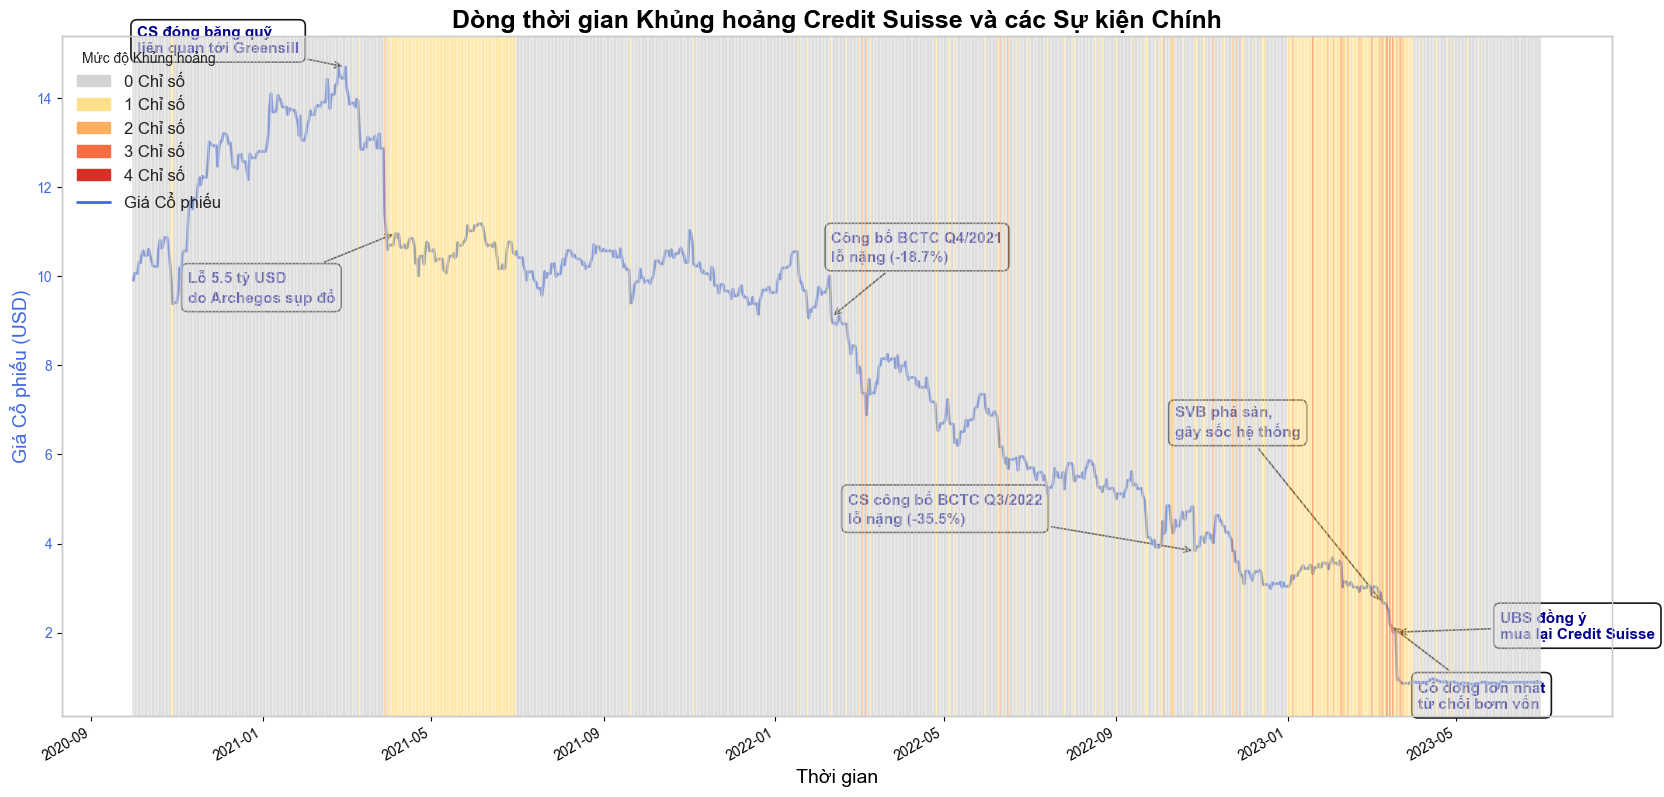

In [6]:
# --- Tính toán "Mức độ Nghiêm trọng" của Khủng hoảng ---
df_model['crisis_severity'] = df_model['Y_Stock'] + df_model['Y_CDS'] + df_model['Y_LCR'] + df_model['Y_CET1']
print("Tính toán mức độ nghiêm trọng của khủng hoảng thành công.")

# --- Trực quan hóa Biểu đồ và Thêm Chú thích ---
print("Đang tạo biểu đồ với các chú thích sự kiện...")

# Tạo Figure và Axes
fig, ax = plt.subplots(figsize=(20, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Vẽ đường giá cổ phiếu
ax.plot(df_model.index, df_model['close_PRICE_CS_1D'], color='royalblue', label='Giá Cổ phiếu Credit Suisse', linewidth=2, zorder=10)

# Thiết lập trục Y chính (cho giá cổ phiếu)
ax.set_ylabel('Giá Cổ phiếu (USD)', fontsize=14, color='royalblue')
ax.tick_params(axis='y', labelcolor='royalblue')
ax.set_title('Dòng thời gian Khủng hoảng Credit Suisse và các Sự kiện Chính', fontsize=18, weight='bold')
ax.set_xlabel('Thời gian', fontsize=14)

# Tạo một trục Y phụ để vẽ các cột nền
ax2 = ax.twinx()

# Tạo bảng màu cho mức độ nghiêm trọng
colors = {0: 'lightgray', 1: '#fee08b', 2: '#fdae61', 3: '#f46d43', 4: '#d73027'}
bar_colors = df_model['crisis_severity'].map(colors)

# Vẽ các cột nền
ax2.bar(df_model.index, [1] * len(df_model), color=bar_colors, width=1.5, alpha=0.5)
ax2.set_yticks([]); ax2.set_ylim(0, 1)

# --- THÊM CHÚ THÍCH SỰ KIỆN (CẬP NHẬT) ---
events = [
    ('2021-03-01', 'CS đóng băng quỹ\nliên quan tới Greensill'),
    ('2021-04-06', 'Lỗ 5.5 tỷ USD\ndo Archegos sụp đổ'),
    ('2022-02-10', 'Công bố BCTC Q4/2021\nlỗ nặng (-18.7%)'), 
    ('2023-03-10', 'SVB phá sản,\ngây sốc hệ thống'),
    ('2023-03-15', 'Cổ đông lớn nhất\ntừ chối bơm vốn'),
    ('2023-03-19', 'UBS đồng ý\nmua lại Credit Suisse'),
    ('27/10/2022', 'CS công bố BCTC Q3/2022\nlỗ nặng (-35.5%)')
]

for date_str, text in events:
    date = pd.to_datetime(date_str)
    # Find the nearest date using get_indexer instead of get_loc
    nearest_idx = df_model.index.get_indexer([date], method='nearest')[0]
    actual_date = df_model.index[nearest_idx]
    price_on_date = df_model.loc[actual_date, 'close_PRICE_CS_1D']
    
    # Điều chỉnh vị trí của text để tránh chồng chéo
    text_offset = (75, -5) # Mặc định
    if 'Greensill' in text: text_offset = (-150, 10)
    if 'Archegos' in text: text_offset = (-150, -50)
    if 'lỗ nặng' in text: text_offset = (0, 40) # Vị trí cho sự kiện mới
    if 'SVB' in text: text_offset = (-150, 120)
    if 'Cổ đông' in text: text_offset = (20, -60)
    if 'CS công bố' in text: text_offset = (-250, 20)

    ax.annotate(text,
            xy=(actual_date, price_on_date),
            xycoords='data',
            xytext=text_offset,
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='black', lw=1.2),
            fontsize=11,
            fontweight='bold',
            color='darkblue',  # chữ đậm màu hơn
            bbox=dict(boxstyle="round,pad=0.4",
                      fc="white",   # nền trắng nổi bật
                      ec="black", 
                      lw=1.2, 
                      alpha=0.9))  # tăng độ rõ

# Tạo chú thích (legend) thủ công
legend_patches = [mpatches.Patch(color=color, label=f'{i} Chỉ số') for i, color in colors.items()]
legend_patches.append(plt.Line2D([0], [0], color='royalblue', lw=2, label='Giá Cổ phiếu'))
plt.legend(handles=legend_patches, title='Mức độ Khủng hoảng', loc='upper left', fontsize=12)

# Định dạng trục X
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

# Lưu biểu đồ
filename = 'crisis_timeline_with_events_final.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Biểu đồ đã được cập nhật và lưu thành công vào file '{filename}'")

plt.show()

#### **Phân tích Biểu đồ**

1.  **Giai đoạn "Bình ổn" (2020 - giữa 2022):**

      * Nhìn vào phần lớn nửa đầu của biểu đồ, ta thấy giá cổ phiếu Credit Suisse (đường màu xanh) dao động nhưng vẫn ở mức tương đối cao và ổn định.
      * Quan trọng hơn, vùng nền trong giai đoạn này gần như hoàn toàn là **màu xám nhạt**. Điều này có nghĩa là rất hiếm có ngày nào có dù chỉ một chỉ số rủi ro được kích hoạt. Điều này gợi ý đây chính là "thời kỳ bình ổn", nếu các mô hình dự đoán học hỏi trên đây có thể cho kết quả không tốt.
    * Mặc dù có sự khủng hoảng sau khi Quỹ phòng hộ Archegos sụp đổ, nhưng điều này xảy ra quá nhanh và đột ngột, giá đã đi ngang ngay sau đó, nên mô hình có thể sẽ không đủ data để phát hiện được suy giảm nhẹ.

2.  **Giai đoạn "Khủng hoảng" (cuối 2022 - 2023):**

      * Mọi thứ thay đổi đột ngột ở phần cuối của biểu đồ. Giá cổ phiếu bắt đầu một chu kỳ sụt giảm mạnh và không thể phục hồi, lao dốc về gần 0.
      * Đồng thời với sự sụp đổ của giá, vùng nền chuyển sang các màu nóng: **vàng, cam, và đỏ sẫm xuất hiện dày đặc**. Điều này cho thấy trong giai đoạn này, không chỉ một mà rất nhiều ngày có 2, 3, và thậm chí cả 4 chỉ số rủi ro của chúng ta cùng lúc báo động. Mức độ nghiêm trọng của khủng hoảng tăng lên rõ rệt.


---

### 2.2 Thử nghiệm Mô hình Dự báo và Sự Thất bại Ban đầu

Với dữ liệu đã được gán nhãn khủng hoảng (`Y_Crisis`), nhóm tiến hành xây dựng mô hình dự báo. nhóm áp dụng phương pháp tiêu chuẩn trong phân tích chuỗi thời gian:
* **Phân chia dữ liệu:** Dữ liệu được chia theo trình tự thời gian thành tập huấn luyện (training set) và tập kiểm thử (test set), đảm bảo mô hình không "nhìn thấy trước" tương lai.
* **Mục tiêu:** Mô hình sẽ học các mẫu hình từ dữ liệu trong quá khứ (tập huấn luyện) để dự đoán các sự kiện trong tương lai gần (tập kiểm thử).

Để kiểm tra tính bền vững của mô hình, nhóm đã tiến hành thử nghiệm một cách hệ thống với nhiều tỷ lệ phân chia dữ liệu khác nhau, từ 90/10 đến 60/40.

#### **Mô hình RandomForest (Rừng Ngẫu nhiên)**

##### Cơ sở lý thuyết

Random Forest là một phương pháp học máy thuộc nhóm **học máy tập thể (ensemble learning)**, hoạt động bằng cách xây dựng một "khu rừng" gồm nhiều "cây quyết định" (decision tree) riêng lẻ. Quá trình này dựa trên hai nguyên tắc chính:

1.  **Bagging (Bootstrap Aggregating):** Mỗi cây trong rừng được huấn luyện trên một mẫu dữ liệu ngẫu nhiên được rút ra từ tập dữ liệu gốc (có lặp lại).
2.  **Random Feature Selection:** Tại mỗi bước phân nhánh của một cây, thay vì xem xét tất cả các biến số, mô hình chỉ chọn một tập hợp con ngẫu nhiên của các biến số để tìm ra cách phân chia tốt nhất.

Sự ngẫu nhiên kép này giúp mỗi cây trong rừng trở nên độc đáo và khác biệt. Khi đưa ra dự đoán, cả khu rừng sẽ "bỏ phiếu" và kết quả cuối cùng được quyết định dựa trên ý kiến của số đông.

##### Lý do lựa chọn

* **Chống quá khớp (Overfitting):** Nhờ cơ chế "trí tuệ tập thể", Random Forest rất mạnh mẽ trong việc giảm thiểu hiện tượng học vẹt, giúp mô hình có khả năng tổng quát hóa tốt trên dữ liệu mới.
* **Khả năng xử lý các mối quan hệ phức tạp:** Mô hình có thể tự động nắm bắt các mối quan hệ phi tuyến tính phức tạp giữa các biến số tài chính và kinh tế vĩ mô mà không cần biến đổi dữ liệu nhiều.

In [7]:
# Tạo một bản sao để thực hiện các tính toán
df_model = df.copy()

# A. Tạo 4 biến Y riêng lẻ như trước
# Y_Stock
df_model['stock_pct_change'] = df_model['close_PRICE_CS_1D'].pct_change()
stock_drop_threshold = df_model['stock_pct_change'].quantile(0.05, interpolation='lower')
df_model['Y_Stock'] = (df_model['stock_pct_change'] <= stock_drop_threshold).astype(int)
# Y_CDS
df_model['cds_change'] = df_model['close_CDS_5Y_CS_1D'].diff()
cds_spike_threshold = df_model['cds_change'].quantile(0.95, interpolation='higher')
df_model['Y_CDS'] = (df_model['cds_change'] >= cds_spike_threshold).astype(int)
# Y_LCR
lcr_col = 'Liquidity Coverage Ratio (LCR)_Internal_Data_Financial_Report'
lcr_low_threshold = df_model[lcr_col].quantile(0.05, interpolation='lower')
df_model['Y_LCR'] = (df_model[lcr_col] <= lcr_low_threshold).astype(int)
# Y_CET1
cet1_col = 'CET1 ratio_Internal_Data_Financial_Report'
cet1_low_threshold = df_model[cet1_col].quantile(0.05, interpolation='lower')
df_model['Y_CET1'] = (df_model[cet1_col] <= cet1_low_threshold).astype(int)

# B. TẠO BIẾN MỤC TIÊU HỢP NHẤT: Y_Crisis
# Y_Crisis = 1 nếu BẤT KỲ tín hiệu rủi ro nào được kích hoạt
df_model['Y_Crisis'] = (df_model['Y_Stock'] | df_model['Y_CDS'] | df_model['Y_LCR'] | df_model['Y_CET1']).astype(int)


print(f"Tổng số ngày có ít nhất một sự kiện rủi ro (Y_Crisis=1): {df_model['Y_Crisis'].sum()}")
print("=" * 50)

# Chuẩn bị dữ liệu đầu vào X và đầu ra Y
features = df.columns.tolist()
X = df_model[features]
X_lagged = X.shift(1) # Dịch chuyển (lag) các feature về 1 ngày
y_crisis = df_model['Y_Crisis']

# Kết hợp và loại bỏ các dòng bị rỗng (NaN)
full_data = pd.concat([X_lagged, y_crisis], axis=1)
full_data_cleaned = full_data.dropna()

# Tách lại X và y cuối cùng
X_final = full_data_cleaned[features]
y_crisis_final = full_data_cleaned['Y_Crisis']

# --- Bước 2: Lặp qua các Tỷ lệ Phân chia, Huấn luyện và Đánh giá ---

# Danh sách các tỷ lệ huấn luyện cần thử nghiệm
train_ratios = [0.9, 0.8, 0.7, 0.6]

for ratio in train_ratios:
    test_ratio_percent = int((1 - ratio) * 100)
    train_ratio_percent = int(ratio * 100)
    
    print(f"\n--- Bắt đầu Thử nghiệm với Tỷ lệ Train/Test: {train_ratio_percent}/{test_ratio_percent} ---")

    # Phân chia dữ liệu theo tỷ lệ hiện tại
    train_size = int(len(X_final) * ratio)
    X_train, X_test = X_final[:train_size], X_final[train_size:]
    y_train, y_test = y_crisis_final[:train_size], y_crisis_final[train_size:]

    print(f"Số mẫu huấn luyện: {len(X_train)} (chứa {y_train.sum()} sự kiện)")
    print(f"Số mẫu kiểm thử: {len(X_test)} (chứa {y_test.sum()} sự kiện)")
    
    # Kiểm tra nếu tập huấn luyện có sự kiện để học không
    if y_train.sum() == 0:
        print(">>> Kết quả: Không có sự kiện (Y=1) trong tập huấn luyện. Không thể huấn luyện mô hình.")
        print("-" * 50)
        continue

    # Khởi tạo mô hình RandomForest
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên tập test
    y_pred = model.predict(X_test)
    
    # Đánh giá và in kết quả
    print(f"\n>>> Classification Report cho tỷ lệ {train_ratio_percent}/{test_ratio_percent}:")
    
    # Kiểm tra nếu tập test có đủ 2 loại nhãn để đánh giá không
    if len(np.unique(y_test)) < 2:
        print("Chỉ có một loại nhãn trong tập kiểm thử, không thể tính toán đầy đủ.")
        print(classification_report(y_test, y_pred, zero_division=0))
    else:
        print(classification_report(y_test, y_pred, zero_division=0))

    print("-" * 50)

Tổng số ngày có ít nhất một sự kiện rủi ro (Y_Crisis=1): 246

--- Bắt đầu Thử nghiệm với Tỷ lệ Train/Test: 90/9 ---
Số mẫu huấn luyện: 901 (chứa 230 sự kiện)
Số mẫu kiểm thử: 101 (chứa 16 sự kiện)

>>> Classification Report cho tỷ lệ 90/9:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        85
           1       0.16      1.00      0.27        16

    accuracy                           0.16       101
   macro avg       0.08      0.50      0.14       101
weighted avg       0.03      0.16      0.04       101

--------------------------------------------------

--- Bắt đầu Thử nghiệm với Tỷ lệ Train/Test: 80/19 ---
Số mẫu huấn luyện: 801 (chứa 147 sự kiện)
Số mẫu kiểm thử: 201 (chứa 99 sự kiện)

>>> Classification Report cho tỷ lệ 80/19:
              precision    recall  f1-score   support

           0       0.48      0.91      0.63       102
           1       0.00      0.00      0.00        99

    accuracy                         

1. **RANDOM FOREST thất bại trong việc dự báo một cách đáng tin cậy**

* **Với các tỷ lệ 80/20 và 60/40:**
    Kết quả cho thấy một quy luật thất bại gần như tuyệt đối: chỉ số **`recall` cho lớp "khủng hoảng" (nhãn 1) bằng 0.00**. Điều này có nghĩa là mô hình đã **không thể nhận diện đúng bất kỳ một ngày khủng hoảng nào** trong tập kiểm thử. Về cơ bản, mô hình chỉ học được rằng trong phần lớn thời gian quá khứ, mọi thứ đều "bình thường", và do đó chiến lược an toàn nhất của nó là luôn dự đoán "bình thường" cho tương lai.

* **Với tỷ lệ 70/30:**
    Ở kịch bản này, mô hình có một chút cải thiện nhỏ khi nhận diện được **8%** số ngày khủng hoảng (`recall` = 0.08). Tuy nhiên, con số này vẫn ở mức cực kỳ thấp và không đủ để được xem là một kết quả hữu ích. Việc bỏ sót đến 92% các trường hợp nguy hiểm là không thể chấp nhận được đối với một hệ thống cảnh báo rủi ro.

* **Với tỷ lệ 90/10:**
    Trường hợp này cho thấy một dạng thất bại khác nhưng cũng không kém phần nghiêm trọng. Ở đây, tập huấn luyện chứa phần lớn các sự kiện khủng hoảng. Tham số `class_weight='balanced'` đã khiến mô hình bù trừ một cách quá mức, dẫn đến việc nó dự đoán **tất cả các ngày trong tập kiểm thử đều là khủng hoảng** (`recall` = 1.00 cho nhãn 1, `recall` = 0.00 cho nhãn 0). Kết quả này cũng hoàn toàn vô dụng trong thực tế.

#### **Mô hình lightGBM (Light Gradient Boosting Machine)**

##### Cơ sở lý thuyết
LightGBM cũng là một phương pháp **học máy tập thể** dựa trên cây quyết định, nhưng nó sử dụng kỹ thuật **Gradient Boosting** thay vì Bagging. Nguyên tắc hoạt động của Gradient Boosting là xây dựng các cây một cách tuần tự: cây sau sẽ học cách sửa chữa những lỗi sai mà cây trước đó đã mắc phải.

Điểm đặc biệt của LightGBM là sự tối ưu hóa vượt trội về tốc độ và hiệu quả xử lý:
1.  **Leaf-wise Growth:** Thay vì phát triển cây theo từng tầng (level-wise) như các thuật toán khác, LightGBM phát triển theo từng nhánh lá (leaf-wise) có khả năng giảm mất mát nhiều nhất, giúp mô hình hội tụ nhanh hơn.
2.  **Tối ưu hóa dữ liệu:** Nó sử dụng các kỹ thuật tiên tiến như Gradient-based One-Side Sampling (GOSS) và Exclusive Feature Bundling (EFB) để giảm đáng kể lượng dữ liệu và số lượng biến số cần xem xét mà không ảnh hưởng nhiều đến độ chính xác.

##### Lý do lựa chọn
* **Hiệu suất vượt trội:** Các mô hình Gradient Boosting như LightGBM thường xuyên đạt được độ chính xác hàng đầu trong các bài toán với dữ liệu dạng bảng. Việc đưa nó vào thử nghiệm giúp khẳng định rằng kết quả của chúng ta không bị giới hạn bởi một loại thuật toán.
* **Tốc độ và Hiệu quả:** LightGBM huấn luyện nhanh hơn và sử dụng ít bộ nhớ hơn đáng kể so với các thuật toán boosting truyền thống, rất phù hợp cho các thử nghiệm lặp lại.
* **Xử lý tốt dữ liệu mất cân bằng:** Tương tự Random Forest, LightGBM có các cơ chế tích hợp (`class_weight`) để xử lý hiệu quả các lớp dữ liệu hiếm, phù hợp với bài toán phát hiện khủng hoảng của chúng ta.

In [8]:
# Tạo một bản sao để thực hiện các tính toán
df_model = df.copy()

# A. Tạo 4 biến Y riêng lẻ
# Y_Stock
df_model['stock_pct_change'] = df_model['close_PRICE_CS_1D'].pct_change()
stock_drop_threshold = df_model['stock_pct_change'].quantile(0.05, interpolation='lower')
df_model['Y_Stock'] = (df_model['stock_pct_change'] <= stock_drop_threshold).astype(int)
# Y_CDS
df_model['cds_change'] = df_model['close_CDS_5Y_CS_1D'].diff()
cds_spike_threshold = df_model['cds_change'].quantile(0.95, interpolation='higher')
df_model['Y_CDS'] = (df_model['cds_change'] >= cds_spike_threshold).astype(int)
# Y_LCR
lcr_col = 'Liquidity Coverage Ratio (LCR)_Internal_Data_Financial_Report'
lcr_low_threshold = df_model[lcr_col].quantile(0.05, interpolation='lower')
df_model['Y_LCR'] = (df_model[lcr_col] <= lcr_low_threshold).astype(int)
# Y_CET1
cet1_col = 'CET1 ratio_Internal_Data_Financial_Report'
cet1_low_threshold = df_model[cet1_col].quantile(0.05, interpolation='lower')
df_model['Y_CET1'] = (df_model[cet1_col] <= cet1_low_threshold).astype(int)

# B. TẠO BIẾN MỤC TIÊU HỢP NHẤT: Y_Crisis
df_model['Y_Crisis'] = (df_model['Y_Stock'] | df_model['Y_CDS'] | df_model['Y_LCR'] | df_model['Y_CET1']).astype(int)

print(f"Tổng số ngày có ít nhất một sự kiện rủi ro (Y_Crisis=1): {df_model['Y_Crisis'].sum()}")
print("=" * 50)

# Chuẩn bị dữ liệu đầu vào X và đầu ra Y
features = df.columns.tolist()
X = df_model[features]
X_lagged = X.shift(1)
y_crisis = df_model['Y_Crisis']

# Kết hợp và loại bỏ các dòng bị rỗng (NaN)
full_data = pd.concat([X_lagged, y_crisis], axis=1)
full_data_cleaned = full_data.dropna()

# Tách lại X và y cuối cùng
X_final = full_data_cleaned[features]
y_crisis_final = full_data_cleaned['Y_Crisis']

# --- Bước 2: Lặp qua các Tỷ lệ Phân chia, Huấn luyện và Đánh giá 2 Mô hình ---

train_ratios = [0.9, 0.8, 0.7, 0.6]

for ratio in train_ratios:
    test_ratio_percent = int((1 - ratio) * 100)
    train_ratio_percent = int(ratio * 100)
    
    print(f"\n--- Bắt đầu Thử nghiệm với Tỷ lệ Train/Test: {train_ratio_percent}/{test_ratio_percent} ---")

    # Phân chia dữ liệu theo tỷ lệ hiện tại
    train_size = int(len(X_final) * ratio)
    X_train, X_test = X_final[:train_size], X_final[train_size:]
    y_train, y_test = y_crisis_final[:train_size], y_crisis_final[train_size:]

    print(f"Số mẫu huấn luyện: {len(X_train)} (chứa {y_train.sum()} sự kiện)")
    print(f"Số mẫu kiểm thử: {len(X_test)} (chứa {y_test.sum()} sự kiện)")
    
    if y_train.sum() == 0:
        print(">>> Kết quả: Không có sự kiện (Y=1) trong tập huấn luyện. Không thể huấn luyện.")
        print("-" * 50)
        continue

    # --- Mô hình 2: LightGBM ---
    lgbm_model = lgb.LGBMClassifier(
        objective='binary',
        class_weight='balanced',
        random_state=42
    )
    lgbm_model.fit(X_train, y_train)
    y_pred_lgbm = lgbm_model.predict(X_test)

    print(f"\n>>> Classification Report (LightGBM) cho tỷ lệ {train_ratio_percent}/{test_ratio_percent}:")
    print(classification_report(y_test, y_pred_lgbm, zero_division=0))
    
    print("-" * 50)

Tổng số ngày có ít nhất một sự kiện rủi ro (Y_Crisis=1): 246

--- Bắt đầu Thử nghiệm với Tỷ lệ Train/Test: 90/9 ---
Số mẫu huấn luyện: 901 (chứa 230 sự kiện)
Số mẫu kiểm thử: 101 (chứa 16 sự kiện)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 230, number of negative: 671
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1996
[LightGBM] [Info] Number of data points in the train set: 901, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

2. **LightGBM cho thấy một vài ưu thế nhỏ nhưng thiếu ổn định**

* Ở các tỷ lệ phân chia 80/20 và 70/30, mô hình LightGBM cho thấy một vài dấu hiệu tích cực hơn so với RandomForest. Cụ thể, nó có khả năng nhận diện được một phần đáng kể các ngày khủng hoảng (chỉ số **`recall`** cho nhãn 1 đạt **0.72** và **0.53**), điều mà RandomForest gần như hoàn toàn thất bại.

* **Tuy nhiên**, ngay cả ở kịch bản tốt nhất (80/20), hiệu suất tổng thể vẫn còn nhiều hạn chế. Chỉ số **`precision`** (độ chính xác) chỉ đạt 0.42, có nghĩa là cứ 10 lần mô hình báo động "khủng hoảng", có gần 6 lần là báo động giả. Mặc dù trong ứng dụng cảnh báo sớm, việc "thà báo động nhầm còn hơn bỏ sót" là có thể chấp nhận được, nhưng tỷ lệ lỗi này vẫn còn cao.

* Sự thiếu ổn định là vấn đề cốt lõi: Khi tỷ lệ train/test bị thay đổi (ví dụ 90/10 hay 60/40), kết quả thu được lại **rất tệ**: mô hình hoặc dự đoán toàn bộ là "khủng hoảng", hoặc ngược lại hoàn toàn bỏ lỡ hết các ngày khủng hoảng. Điều này phản ánh sự **nhạy cảm mạnh mẽ của LightGBM với cách chia dữ liệu** và cho thấy nó không học được một quy luật tổng quát.

* **=> Kết luận này củng cố thêm lý do để chúng ta thử nghiệm điều chỉnh ngưỡng quyết định (threshold)**, nhằm tìm ra một điểm cân bằng tốt hơn giữa việc phát hiện rủi ro và giảm thiểu báo động giả.

#### Mô hình lightGBM - Hạ thấp ngưỡng quyết định (threshold)

**Cơ sở Lập luận: Ưu tiên Độ nhạy (Recall) trong Cảnh báo Sớm**

Trong các mô hình phân loại, luôn có một sự **đánh đổi giữa Độ chính xác (Precision) và Độ nhạy (Recall)**.

  * **Precision (Độ chính xác):** Trong số tất cả những lần mô hình hô "khủng hoảng", có bao nhiêu lần là khủng hoảng thật?

      * *Precision cao có nghĩa là mô hình ít khi báo động giả.*

  * **Recall (Độ nhạy):** Trong số tất cả những ngày khủng hoảng thật sự đã xảy ra, mô hình phát hiện (bắt) được bao nhiêu ngày?

      * *Recall cao có nghĩa là mô hình ít khi bỏ sót các sự kiện nguy hiểm.*

Đối với bài toán này, chi phí của việc bỏ sót một cuộc khủng hoảng (False Negative) là cực kỳ lớn, có thể dẫn đến sự sụp đổ. Ngược lại, chi phí của một lần báo động giả (False Positive) chỉ đơn giản là khiến chúng ta phải kiểm tra kỹ hơn.

Do đó, quan tâm đến việc "mô hình bắt được bao nhiêu ngày khủng hoảng thật" là một chiến lược hoàn toàn đúng đắn. Chúng ta sẵn sàng chấp nhận `precision` thấp hơn một chút để đổi lấy `recall` cao hơn.

**Làm thế nào để tăng Recall?**

Một mô hình phân loại không chỉ dự đoán `0` hay `1`. Nó đưa ra một **xác suất** (ví dụ: 0.67). Mặc định, nếu xác suất \> 0.5, nó sẽ dự đoán là `1` (khủng hoảng). Để tăng Recall, chúng ta chỉ cần **hạ thấp ngưỡng quyết định (threshold)** này xuống. Ví dụ, ta có thể quy định rằng: "Nếu xác suất khủng hoảng \> 0.3 (thay vì 0.5), hãy báo động\!". Khi đó, mô hình sẽ "nhạy" hơn, bắt được nhiều trường hợp hơn, và `recall` sẽ tăng lên.

Dưới đây là đoạn mã để kiểm chứng điều này với mô hình LightGBM trên tỷ lệ 80/20, thử nghiệm với các ngưỡng khác nhau.

In [9]:
# Tạo một bản sao để thực hiện các tính toán
df_model = df.copy()

# A. Tạo 4 biến Y riêng lẻ
df_model['stock_pct_change'] = df_model['close_PRICE_CS_1D'].pct_change()
stock_drop_threshold = df_model['stock_pct_change'].quantile(0.05, interpolation='lower')
df_model['Y_Stock'] = (df_model['stock_pct_change'] <= stock_drop_threshold).astype(int)
df_model['cds_change'] = df_model['close_CDS_5Y_CS_1D'].diff()
cds_spike_threshold = df_model['cds_change'].quantile(0.95, interpolation='higher')
df_model['Y_CDS'] = (df_model['cds_change'] >= cds_spike_threshold).astype(int)
lcr_col = 'Liquidity Coverage Ratio (LCR)_Internal_Data_Financial_Report'
lcr_low_threshold = df_model[lcr_col].quantile(0.05, interpolation='lower')
df_model['Y_LCR'] = (df_model[lcr_col] <= lcr_low_threshold).astype(int)
cet1_col = 'CET1 ratio_Internal_Data_Financial_Report'
cet1_low_threshold = df_model[cet1_col].quantile(0.05, interpolation='lower')
df_model['Y_CET1'] = (df_model[cet1_col] <= cet1_low_threshold).astype(int)

# B. TẠO BIẾN MỤC TIÊU HỢP NHẤT: Y_Crisis
df_model['Y_Crisis'] = (df_model['Y_Stock'] | df_model['Y_CDS'] | df_model['Y_LCR'] | df_model['Y_CET1']).astype(int)
print(f"Tổng số ngày có ít nhất một sự kiện rủi ro (Y_Crisis=1): {df_model['Y_Crisis'].sum()}")
print("=" * 50)

# Chuẩn bị dữ liệu đầu vào X và đầu ra Y
features = df.columns.tolist()
X = df_model[features]
X_lagged = X.shift(1)
y_crisis = df_model['Y_Crisis']
full_data = pd.concat([X_lagged, y_crisis], axis=1)
full_data_cleaned = full_data.dropna()
X_final = full_data_cleaned[features]
y_crisis_final = full_data_cleaned['Y_Crisis']

# --- Bước 2: Huấn luyện Mô hình trên tỷ lệ 80/20 ---

ratio = 0.8
train_size = int(len(X_final) * ratio)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_crisis_final[:train_size], y_crisis_final[train_size:]

print(f"Sử dụng tỷ lệ Train/Test: {int(ratio*100)}/{int((1-ratio)*100)}")
print(f"Số mẫu huấn luyện: {len(X_train)} (chứa {y_train.sum()} sự kiện)")
print(f"Số mẫu kiểm thử: {len(X_test)} (chứa {y_test.sum()} sự kiện)")

lgbm_model = lgb.LGBMClassifier(
    objective='binary',
    class_weight='balanced',
    random_state=42
)
lgbm_model.fit(X_train, y_train)

# Lấy xác suất dự đoán thay vì nhãn 0/1
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

print("=" * 50)

# --- Bước 3: Đánh giá với các Ngưỡng (Threshold) khác nhau ---

thresholds = [0.5, 0.45, 0.4, 0.35, 0.3]

for thr in thresholds:
    print(f"\n--- Kết quả với Ngưỡng quyết định = {thr} ---")
    
    # Áp dụng ngưỡng mới để ra quyết định 0/1
    y_pred_new_threshold = (y_pred_proba >= thr).astype(int)
    
    # In báo cáo
    print(classification_report(y_test, y_pred_new_threshold, zero_division=0))

Tổng số ngày có ít nhất một sự kiện rủi ro (Y_Crisis=1): 246
Sử dụng tỷ lệ Train/Test: 80/19
Số mẫu huấn luyện: 801 (chứa 147 sự kiện)
Số mẫu kiểm thử: 201 (chứa 99 sự kiện)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 147, number of negative: 654
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1953
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

##### **Quan sát Xu hướng chính**

Khi chúng ta hạ ngưỡng quyết định từ **0.5** xuống **0.3**:

* **`recall` (Độ nhạy) cho lớp 1 TĂNG ĐỀU:**
    * Ngưỡng 0.5: `recall` = 0.72 (bắt được **72%** số ngày khủng hoảng thật)
    * Ngưỡng 0.45: `recall` = 0.74 (bắt được **74%**)
    * Ngưỡng 0.4: `recall` = 0.80 (bắt được **80%**)
    * Ngưỡng 0.35: `recall` = 0.81 (bắt được **81%**)
    * Ngưỡng 0.3: `recall` = 0.82 (bắt được **82%**)

    => **Diễn giải:** Thử nghiệm này đã **thành công** trong việc đạt được mục tiêu đề ra. Bằng cách giảm ngưỡng, chúng ta đã làm cho mô hình "nhạy" hơn và bắt được ngày càng nhiều các sự kiện khủng hoảng thật sự. Ở ngưỡng 0.3, mô hình đã có thể phát hiện được 82% tổng số các ngày khủng hoảng thật sự trong tập kiểm thử.

* **`precision` (Độ chính xác) cho lớp 1 KHÁ ỔN ĐỊNH:**
    * `precision` dao động trong khoảng 0.42 - 0.45.
    * => **Diễn giải:** Điều này có nghĩa là, khi mô hình báo động "khủng hoảng", tỷ lệ nó đúng là khoảng 42-46%. Mặc dù không cao, nhưng việc nó không giảm sâu khi chúng ta tăng `recall` là một tín hiệu tương đối tích cực. Chúng ta bắt được nhiều khủng hoảng hơn mà không tạo ra thêm quá nhiều báo động giả.

* **Sự Đánh đổi thể hiện ở Lớp 0 (ngày bình thường):**
    * Khi chúng ta hạ ngưỡng, `recall` của lớp 0 giảm mạnh (từ 0.17 xuống 0.03).
    * => **Diễn giải:** Đây chính là sự đánh đổi. Để bắt được nhiều ngày khủng hoảng hơn (nhãn 1), mô hình đã phải hy sinh khả năng nhận diện đúng các ngày bình thường (nhãn 0). Nó đã phân loại nhầm rất nhiều ngày bình thường thành ngày khủng hoảng.


---


### **2.3 Kết luận và Hướng đi mới**

1.  **Chúng ta CÓ THỂ điều chỉnh mô hình để ưu tiên việc "bắt" khủng hoảng:** Thử nghiệm này chứng tỏ rằng bằng cách điều chỉnh ngưỡng quyết định, chúng ta có thể tạo ra một hệ thống cảnh báo sớm có độ nhạy cao, đáp ứng yêu cầu "không bỏ sót nguy hiểm". Nếu phải chọn, một ngưỡng như **0.3** hoặc **0.35** sẽ là lựa chọn tốt nhất để tối đa hóa khả năng phát hiện khủng hoảng.

2.  **Mô hình vẫn còn nhiều hạn chế:** Mặc dù đã được "ép" để trở nên nhạy hơn, độ chính xác tổng thể (`accuracy`) của mô hình vẫn rất thấp (dưới 50%). Điều này gợi ý bản chất dữ liệu, mô hình này không thể trở thành một công cụ dự báo chính xác tuyệt đối. Nó giống như một hệ thống "báo động cháy" rất nhạy: nó sẽ kêu khi có khói, nhưng đôi khi nó cũng sẽ kêu khi chỉ đang nướng bánh mì.

Tóm lại, thử nghiệm này là một bước rất giá trị. Nó cho thấy dù không thể dự báo một cách hoàn hảo, chúng ta vẫn có thể tinh chỉnh mô hình để nó phục vụ tốt nhất cho mục tiêu **cảnh báo sớm và không bỏ sót rủi ro.**


## 3. HƯỚNG TIẾP CẬN PHÂN TÍCH VÀ DIỄN GIẢI

Sau đây, thay vì cố gắng dự đoán một sự kiện chính xác, nhóm sẽ phân tích các chỉ số có ảnh hưởng mật thiết nhất tới các ngày rủi ro đó (Feature Importance Analysis). Mục tiêu của phương pháp này không phải là để "dự báo thời điểm" khủng hoảng một cách trực tiếp, mà là để **"đo lường"** mức độ ảnh hưởng của từng yếu tố rủi ro.

Bằng cách xác định được những chỉ số nào có tác động mạnh nhất đến các ngày khủng hoảng trong quá khứ, chúng ta có thể cung cấp một cơ sở định lượng vững chắc để xây dựng các hệ thống theo dõi và cảnh báo sớm hiệu quả hơn trong tương lai. Phần tiếp theo sẽ trình bày kết quả phân tích này.

### **3.1. Cơ sở lý thuyết của Feature Importance**

Feature Importance (Mức độ quan trọng của Biến số) là một kỹ thuật trong học máy nhằm gán một điểm số cho mỗi biến số đầu vào (feature) dựa trên mức độ hữu ích của nó trong việc dự đoán biến mục tiêu. Đối với các mô hình dựa trên cây quyết định như Random Forest và LightGBM, điểm số này thường được tính toán dựa trên cơ chế **"Mean Decrease in Impurity" (Mức giảm Trung bình của Tạp chất)**.

Cơ chế này hoạt động như sau:
1.  Khi xây dựng một cây quyết định, tại mỗi nút, thuật toán sẽ lựa chọn một biến số và một ngưỡng để phân nhánh sao cho hai nhóm con tạo ra là "thuần khiết" nhất có thể (ví dụ: chứa nhiều nhất các ngày "khủng hoảng" hoặc "bình thường").
2.  Mức độ "thuần khiết" này được đo lường bằng một chỉ số gọi là "tạp chất" (impurity), ví dụ như Gini impurity hoặc Entropy. Mỗi lần phân nhánh, mức độ tạp chất của các nút con sẽ giảm so với nút cha.
3.  Mức độ quan trọng của một biến số được tính bằng tổng mức giảm tạp chất mà nó mang lại trên tất cả các cây trong rừng mỗi khi nó được chọn để phân nhánh.

Một biến số có điểm Feature Importance cao có nghĩa là nó đã được mô hình liên tục sử dụng để tạo ra các quyết định phân loại quan trọng và hiệu quả, giúp phân biệt rõ ràng giữa các ngày bình thường và ngày khủng hoảng.

### **3.2. Lý do áp dụng**

Việc áp dụng phương pháp Feature Importance Analysis trong nghiên cứu này được thúc đẩy bởi những lý do chính sau:

* **Vượt qua hạn chế của mô hình dự báo:** Khi các thử nghiệm cho thấy việc dự báo chính xác thời điểm khủng hoảng là không khả thi do tính chất "thiên nga đen" của dữ liệu, Feature Importance nổi lên như một công cụ thay thế mạnh mẽ. Nó cho phép chúng ta khai thác toàn bộ bộ dữ liệu (bao gồm cả giai đoạn khủng hoảng) để rút ra những hiểu biết mang tính diễn giải.
* **Tăng cường khả năng Diễn giải (Interpretability):** Thay vì chỉ nhận được một kết quả dự đoán "có" hoặc "không", phương pháp này giúp mở "hộp đen" của mô hình. Nó cho chúng ta biết *tại sao* mô hình lại nghiêng về một quyết định nào đó, bằng cách chỉ ra các yếu tố có sức ảnh hưởng lớn nhất.
* **Đáp ứng mục tiêu "Đo lường" Rủi ro:** Phương pháp này trực tiếp đáp ứng yêu cầu "đo lường" trong đề tài. Nó cung cấp một thước đo định lượng để xếp hạng mức độ tác động của hàng chục biến số tài chính và vĩ mô, giúp xác định đâu là tín hiệu nhiễu và đâu là tín hiệu cảnh báo trọng yếu.
* **Nền tảng cho Hệ thống Cảnh báo trong Tương lai:** Bằng cách xác định được các chỉ số quan trọng nhất (ví dụ: VIX, Chi phí dự phòng rủi ro tín dụng...), kết quả phân tích sẽ là cơ sở để thiết kế các bảng theo dõi (dashboard) rủi ro hiệu quả, giúp các nhà phân tích tập trung sự chú ý vào đúng những tín hiệu cần thiết.

### 3.3 Chuẩn bị Dữ liệu Đầu vào (X)

In [10]:
# Chọn các cột gốc làm biến đầu vào
features = df.columns.tolist()
X = df_model[features]

# Dịch chuyển (lag) các biến đầu vào về 1 ngày để tránh rò rỉ dữ liệu
# Mô hình sẽ dùng dữ liệu của ngày t-1 để giải thích cho sự kiện ở ngày t
X_lagged = X.shift(1)

# Xác định 4 biến mục tiêu
y_stock = df_model['Y_Stock']
y_cds = df_model['Y_CDS']
y_lcr = df_model['Y_LCR']
y_cet1 = df_model['Y_CET1']

# Kết hợp tất cả lại và loại bỏ các dòng bị rỗng (NaN)
# Các dòng NaN phát sinh do các phép tính .diff(), .pct_change(), và .shift()
full_data = pd.concat([X_lagged, y_stock, y_cds, y_lcr, y_cet1], axis=1)
full_data_cleaned = full_data.dropna()

# Tách lại thành X và y cuối cùng để sẵn sàng cho mô hình
X_final = full_data_cleaned[features]
y_stock_final = full_data_cleaned['Y_Stock']
y_cds_final = full_data_cleaned['Y_CDS']
y_lcr_final = full_data_cleaned['Y_LCR']
y_cet1_final = full_data_cleaned['Y_CET1']

print(f"\nKích thước dữ liệu cuối cùng sau khi làm sạch: {X_final.shape}")


Kích thước dữ liệu cuối cùng sau khi làm sạch: (1002, 26)


### 3.4 Hàm Huấn luyện Mô hình và Trích xuất Tầm quan trọng

In [11]:
def train_and_get_feature_importance(X_data, y_data, model_name):
    """
    Hàm này huấn luyện mô hình RandomForest trên 100% dữ liệu được cung cấp
    và trả về một Series chứa mức độ quan trọng của các biến số, đã được sắp xếp.
    """
    print(f"\n--- Đang huấn luyện mô hình cho: {model_name} ---")
    
    # Kiểm tra xem có sự kiện nào không
    if y_data.sum() == 0:
        print(f"Không có sự kiện (Y=1) cho {model_name}. Không thể huấn luyện.")
        return None
    
    # Khởi tạo mô hình RandomForestClassifier
    # class_weight='balanced' giúp mô hình chú ý hơn đến các sự kiện hiếm (Y=1)
    model = RandomForestClassifier(
        n_estimators=100,       # Số lượng "cây" trong "rừng"
        class_weight='balanced',
        random_state=42,
        n_jobs=-1               # Sử dụng tất cả các nhân CPU có sẵn để tăng tốc
    )
    
    # Huấn luyện mô hình trên toàn bộ dữ liệu
    model.fit(X_data, y_data)
    
    # Trích xuất và sắp xếp mức độ quan trọng
    importances = pd.Series(model.feature_importances_, index=X_data.columns)
    sorted_importances = importances.sort_values(ascending=False)
    
    print(f"Huấn luyện thành công.")
    return sorted_importances

### 3.5 Thực thi Phân tích cho 4 Mô hình

In [12]:
# Chạy hàm phân tích cho cả 4 mô hình và lưu kết quả
fi_stock = train_and_get_feature_importance(X_final, y_stock_final, "Y_Stock (Sụt giảm Cổ phiếu)")
fi_cds = train_and_get_feature_importance(X_final, y_cds_final, "Y_CDS (Tăng vọt CDS)")
fi_lcr = train_and_get_feature_importance(X_final, y_lcr_final, "Y_LCR (Rủi ro Thanh khoản)")
fi_cet1 = train_and_get_feature_importance(X_final, y_cet1_final, "Y_CET1 (Rủi ro Vốn)")

# In ra 5 yếu tố hàng đầu cho mỗi mô hình
print("\n--- Top 5 Yếu tố Quan trọng nhất cho mỗi Mô hình ---")
if fi_stock is not None: print("\nSụt giảm Cổ phiếu:\n", fi_stock.head(5))
if fi_cds is not None: print("\nTăng vọt CDS:\n", fi_cds.head(5))
if fi_lcr is not None: print("\nRủi ro Thanh khoản (LCR):\n", fi_lcr.head(5))
if fi_cet1 is not None: print("\nRủi ro Vốn (CET1):\n", fi_cet1.head(5))


--- Đang huấn luyện mô hình cho: Y_Stock (Sụt giảm Cổ phiếu) ---
Huấn luyện thành công.

--- Đang huấn luyện mô hình cho: Y_CDS (Tăng vọt CDS) ---
Huấn luyện thành công.

--- Đang huấn luyện mô hình cho: Y_LCR (Rủi ro Thanh khoản) ---
Huấn luyện thành công.

--- Đang huấn luyện mô hình cho: Y_CET1 (Rủi ro Vốn) ---
Huấn luyện thành công.

--- Top 5 Yếu tố Quan trọng nhất cho mỗi Mô hình ---

Sụt giảm Cổ phiếu:
 volume_PRICE_CS_1D                  0.113782
close_CBOE_Volatility_Index_FRED    0.105284
close_SX7E_STOXX_Banks_EUR_Price    0.104168
close_PRICE_CS_1D                   0.102458
volume_SP_500_1D                    0.096409
dtype: float64

Tăng vọt CDS:
 volume_PRICE_CS_1D                  0.144264
close_CDS_5Y_CS_1D                  0.139302
close_PRICE_CS_1D                   0.108920
close_CBOE_Volatility_Index_FRED    0.077197
volume_SP_500_1D                    0.075126
dtype: float64

Rủi ro Thanh khoản (LCR):
 Liquidity Coverage Ratio (LCR)_Internal_Data_Financial_Report

### 3.6 Hàm Trực quan hóa và Tạo Biểu đồ

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6880\4185209482.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')


Đã lưu biểu đồ vào file: stock_importance.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6880\4185209482.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')


Đã lưu biểu đồ vào file: cds_importance.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6880\4185209482.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')


Đã lưu biểu đồ vào file: lcr_importance.png


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6880\4185209482.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')


Đã lưu biểu đồ vào file: cet1_importance.png


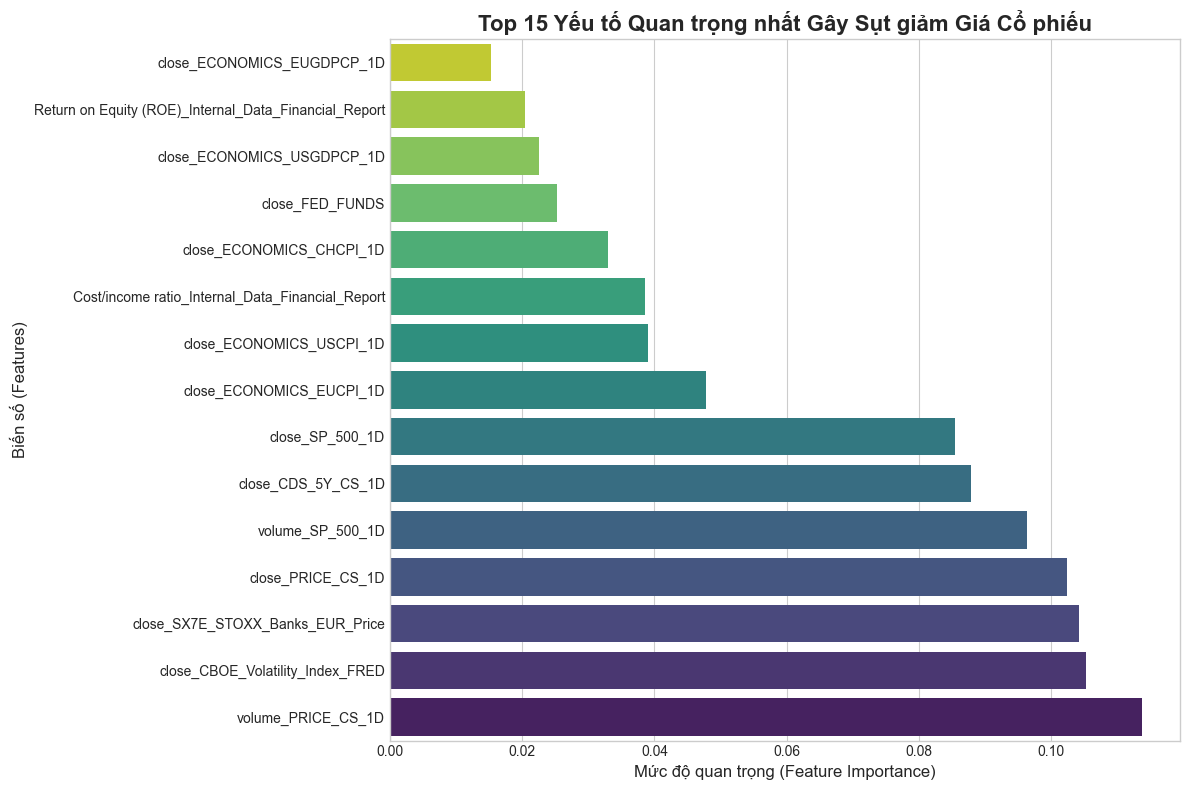

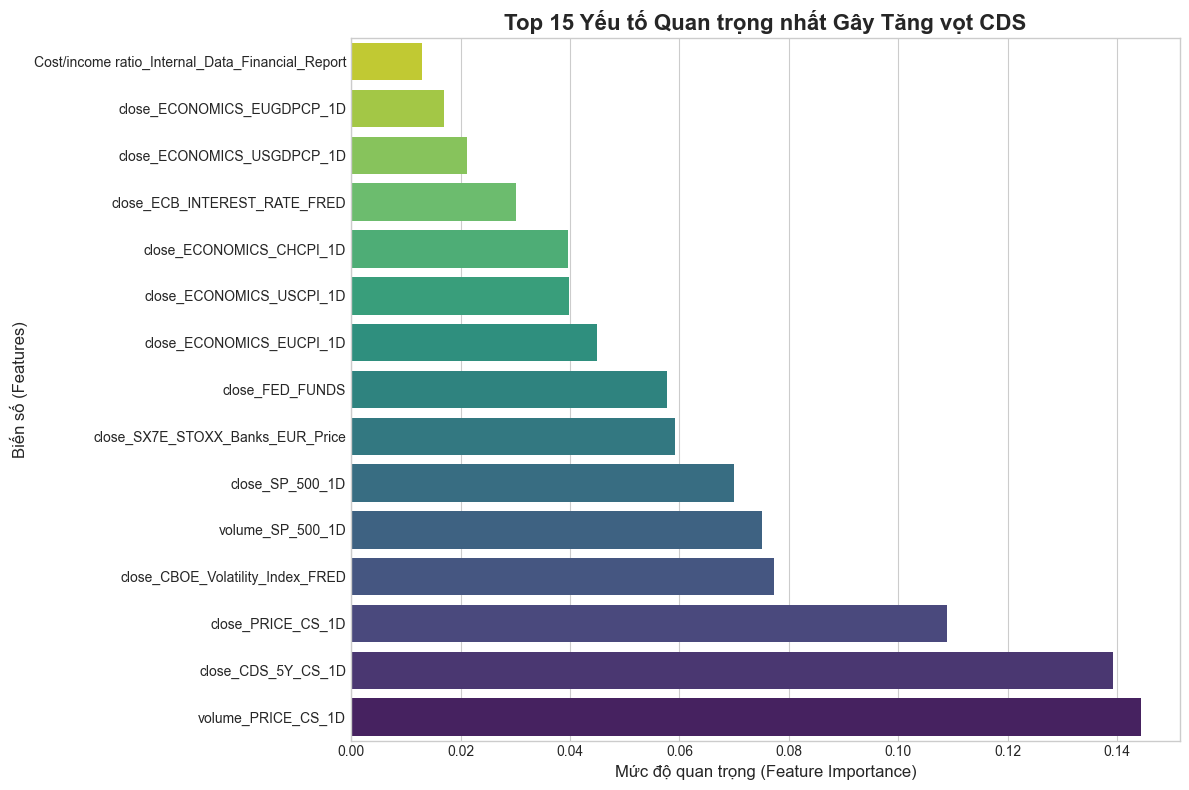

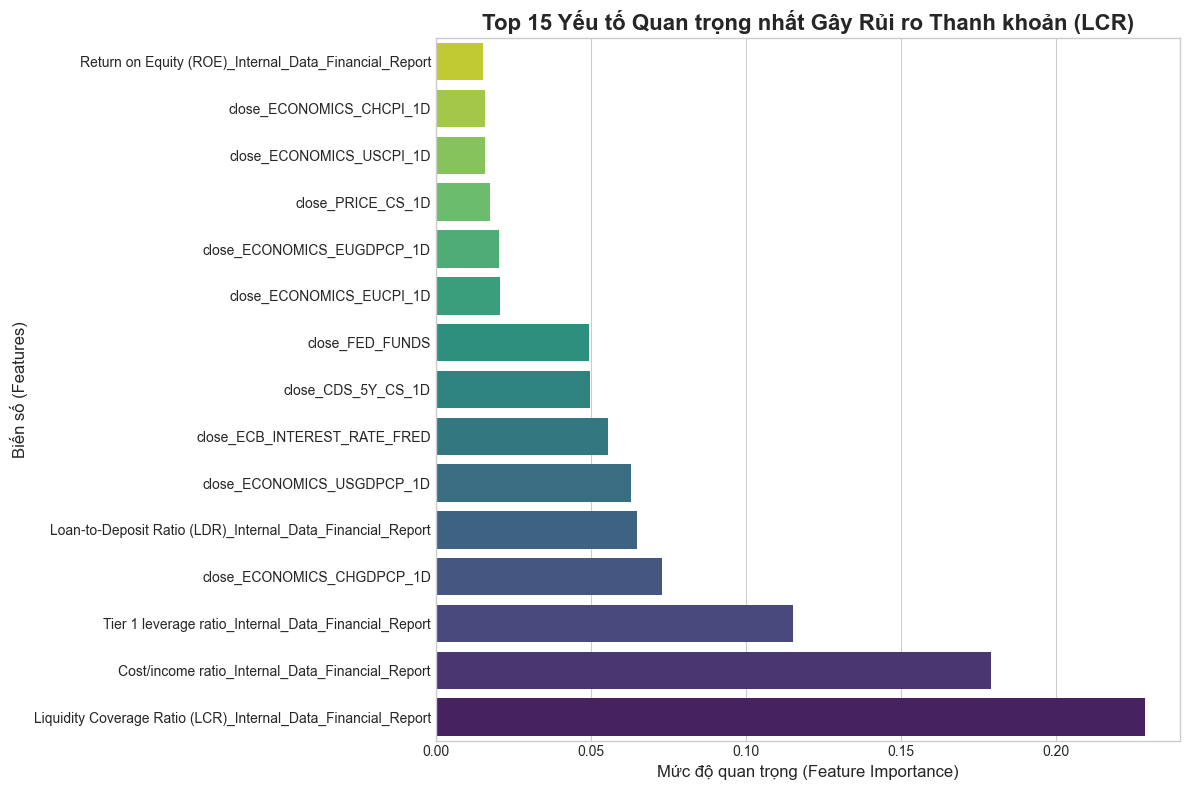

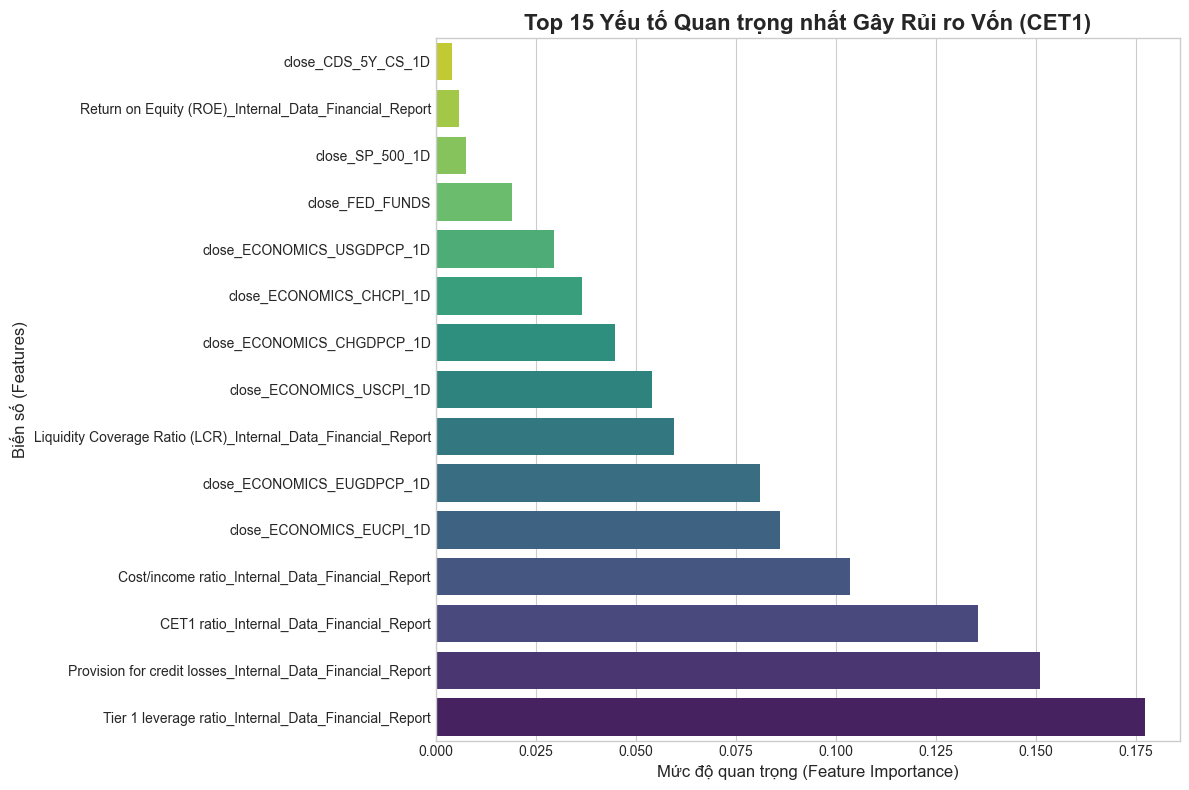

In [13]:
def plot_feature_importance(fi_series, title, filename):
    """
    Hàm này nhận vào một Series chứa mức độ quan trọng và vẽ biểu đồ cột,
    sau đó lưu lại thành file ảnh.
    """
    if fi_series is not None:
        # Lấy 15 yếu tố hàng đầu để vẽ
        top_15 = fi_series.head(15)
        
        plt.style.use('seaborn-v0_8-whitegrid') # Sử dụng style cho đẹp hơn
        plt.figure(figsize=(12, 8))
        
        sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')
        
        plt.title(title, fontsize=16, weight='bold')
        plt.xlabel('Mức độ quan trọng (Feature Importance)', fontsize=12)
        plt.ylabel('Biến số (Features)', fontsize=12)
        
        # Đảo ngược trục y để biến quan trọng nhất ở trên cùng
        plt.gca().invert_yaxis()
        
        plt.tight_layout() # Tự động căn chỉnh cho vừa vặn
        plt.savefig(filename)
        print(f"Đã lưu biểu đồ vào file: {filename}")

# Tạo và lưu 4 biểu đồ
plot_feature_importance(fi_stock, 'Top 15 Yếu tố Quan trọng nhất Gây Sụt giảm Giá Cổ phiếu', 'stock_importance.png')
plot_feature_importance(fi_cds, 'Top 15 Yếu tố Quan trọng nhất Gây Tăng vọt CDS', 'cds_importance.png')
plot_feature_importance(fi_lcr, 'Top 15 Yếu tố Quan trọng nhất Gây Rủi ro Thanh khoản (LCR)', 'lcr_importance.png')
plot_feature_importance(fi_cet1, 'Top 15 Yếu tố Quan trọng nhất Gây Rủi ro Vốn (CET1)', 'cet1_importance.png')

### 3.7 Phân tích Mức độ Quan trọng của các Biến số và nhận xét kết quả

#### 1. Các yếu tố Gây **Sụt giảm Giá Cổ phiếu**

Biểu đồ này cho thấy các tín hiệu thị trường là yếu tố ảnh hưởng lớn nhất đến sự biến động giá cổ phiếu của **Credit Suisse**.

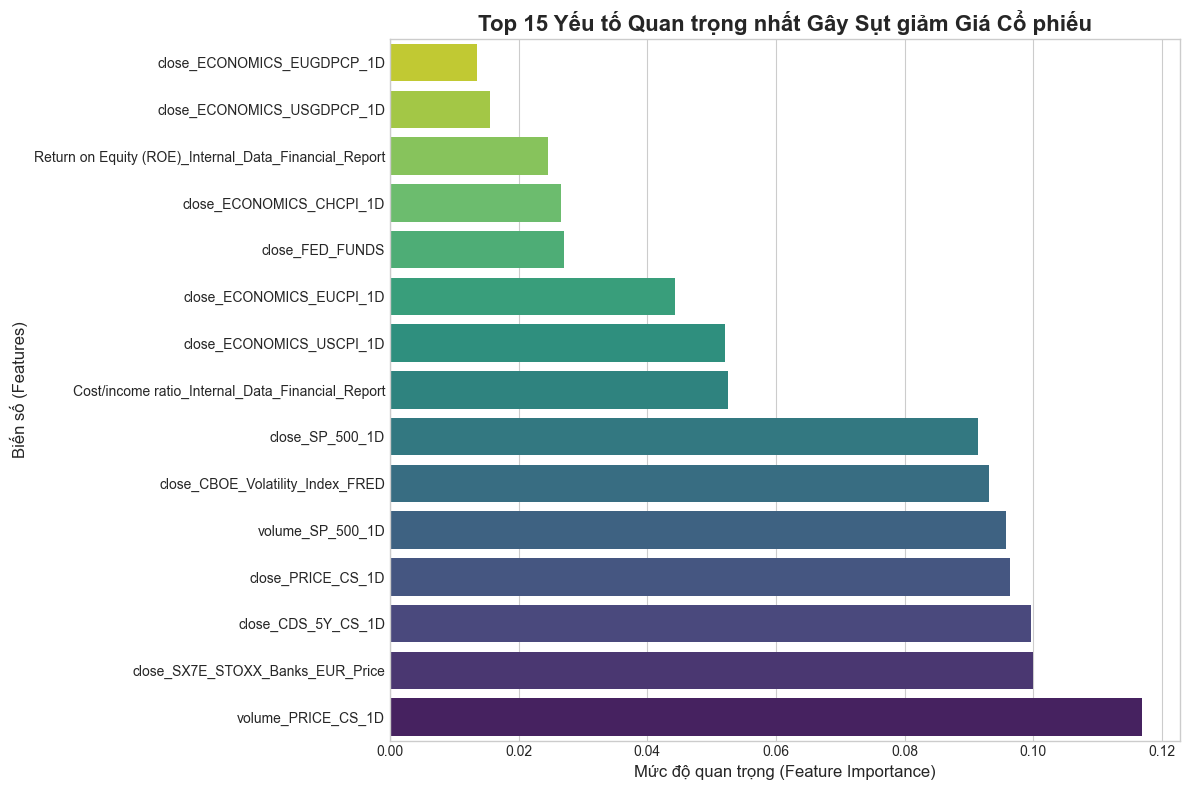
Top 5 yếu tố quan trọng nhất:
- **Khối lượng Giao dịch Cổ phiếu CS (`volume_PRICE_CS_1D`)**  
  → Sự sụt giảm giá mạnh thường đi kèm với khối lượng giao dịch đột biến, cho thấy sự hoảng loạn và áp lực bán tháo.

- **Giá Cổ phiếu CS (`close_PRICE_CS_1D`)**  
  → Giá ngày hôm trước là một chỉ báo mạnh cho ngày hôm sau, thể hiện sự tiếp diễn của xu hướng.

- **Chỉ số Biến động VIX (`close_CBOE_Volatility_Index_FRED`)**  
  → "Chỉ số sợ hãi" VIX tăng cao cho thấy sự bất ổn trên toàn thị trường, tác động tiêu cực đến giá cổ phiếu ngân hàng.

- **Giá CDS 5 năm của CS (`close_CDS_5Y_CS_1D`)**  
  → Khi rủi ro vỡ nợ (CDS) tăng, niềm tin của nhà đầu tư giảm, trực tiếp gây áp lực lên giá cổ phiếu.

- **Chỉ số Ngân hàng Châu Âu (`close_SX7E_STOXX_Banks_EUR_Price`)**  
  → Giá cổ phiếu CS di chuyển cùng pha với ngành ngân hàng châu Âu, cho thấy rủi ro mang tính hệ thống.

---



#### 2. Các yếu tố Gây **Tăng vọt CDS**

Mô hình này chỉ ra rằng rủi ro tín dụng của **Credit Suisse** được định giá chủ yếu dựa trên chính các chỉ số nội tại và tình hình thị trường chung.

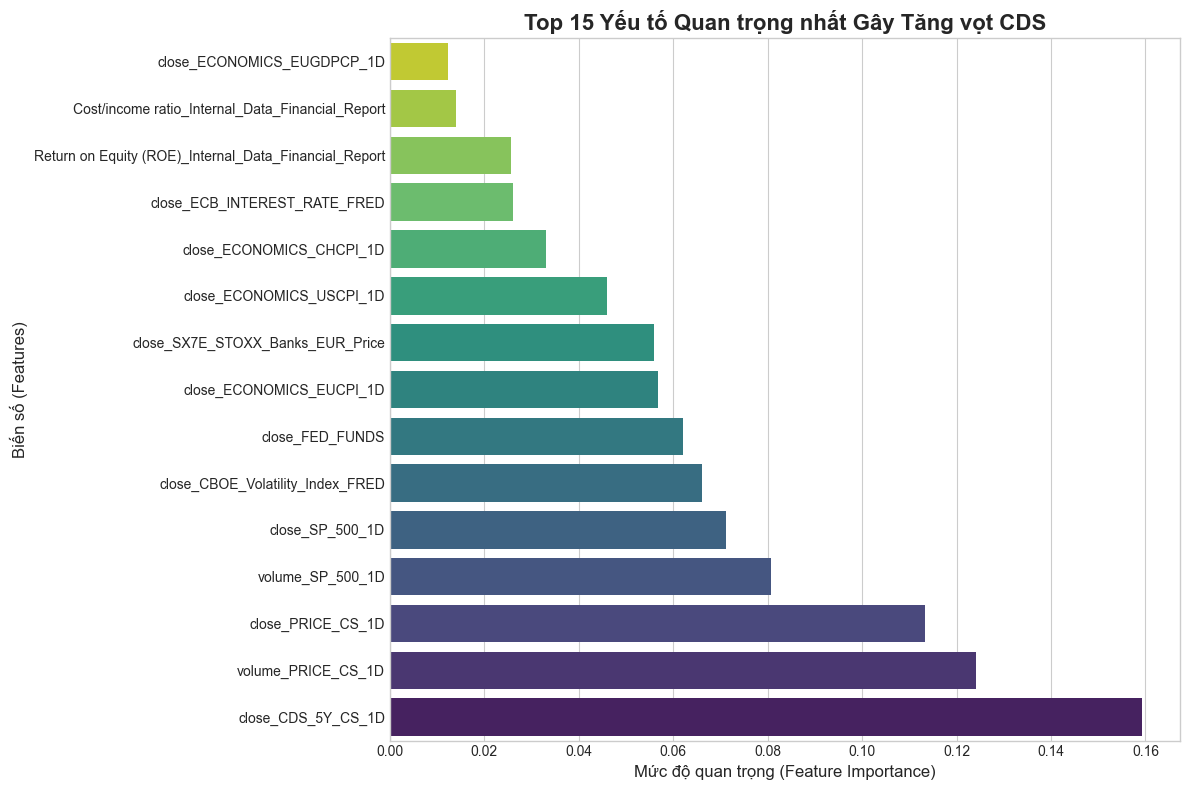

Top 5 yếu tố quan trọng nhất:
- **Giá CDS 5 năm của CS (`close_CDS_5Y_CS_1D`)**  
  → Tính tự tương quan cao, giá CDS hiện tại chịu ảnh hưởng mạnh từ giá trước đó.

- **Giá Cổ phiếu CS (`close_PRICE_CS_1D`)**  
  → Mối quan hệ nghịch đảo kinh điển: giá cổ phiếu giảm làm tăng nhận thức rủi ro, đẩy CDS lên cao.

- **Khối lượng Giao dịch Cổ phiếu CS (`volume_PRICE_CS_1D`)**  
  → Khối lượng giao dịch cao cho thấy sự chú ý của thị trường, khuếch đại biến động CDS.

- **Chỉ số S&P 500 (`close_SP_500_1D`)**  
  → Sức khỏe thị trường Mỹ ảnh hưởng lan tỏa đến rủi ro của một ngân hàng toàn cầu như CS.

- **Khối lượng Giao dịch S&P 500 (`volume_SP_500_1D`)**  
  → Giao dịch lớn tại Mỹ thường trùng với ngày biến động mạnh, ảnh hưởng đến CDS.

---



#### 3. Các yếu tố Gây **Rủi ro Thanh khoản (LCR)**

Mô hình này cho thấy rủi ro thanh khoản của **Credit Suisse** bị ảnh hưởng bởi cả hiệu quả hoạt động nội tại và sức khỏe kinh tế toàn cầu.

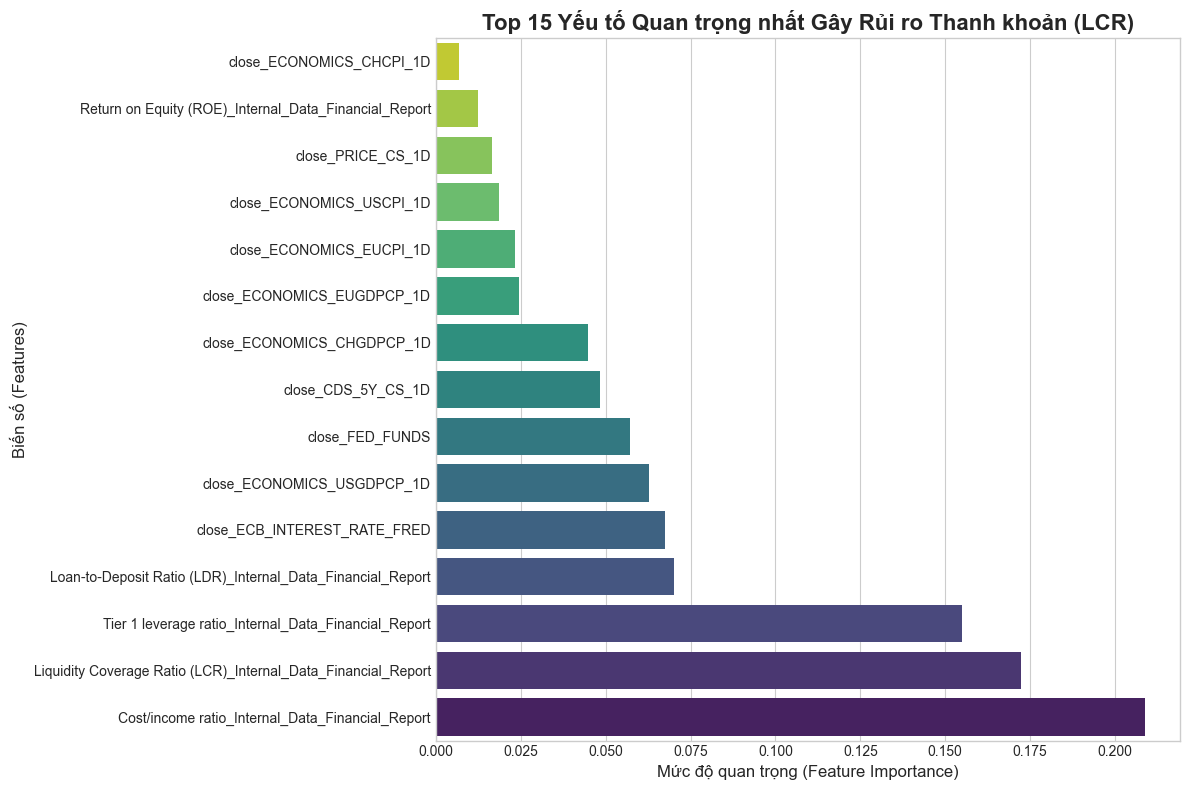

Top 5 yếu tố quan trọng nhất:
- **Chính chỉ số LCR**  
  → LCR trong quá khứ là yếu tố dự báo tốt nhất cho chính nó.

- **Tỷ lệ Chi phí/Thu nhập (Cost/income ratio)**  
  → Tỷ lệ cao cho thấy ngân hàng hoạt động kém hiệu quả, lợi nhuận bị bào mòn.

- **GDP Hoa Kỳ (`close_ECONOMICS_USGDPCP_1D`)**  
  → Kinh tế Mỹ ảnh hưởng đến hoạt động toàn cầu và dòng vốn.

- **Tỷ lệ đòn bẩy Cấp 1 (Tier 1 leverage ratio)**  
  → Chỉ số vốn quan trọng, phản ánh khả năng chống chịu.

- **GDP Thụy Sĩ (`close_ECONOMICS_CHGDPCP_1D`)**  
  → Sức khỏe kinh tế sân nhà ảnh hưởng trực tiếp đến hoạt động của CS.

---

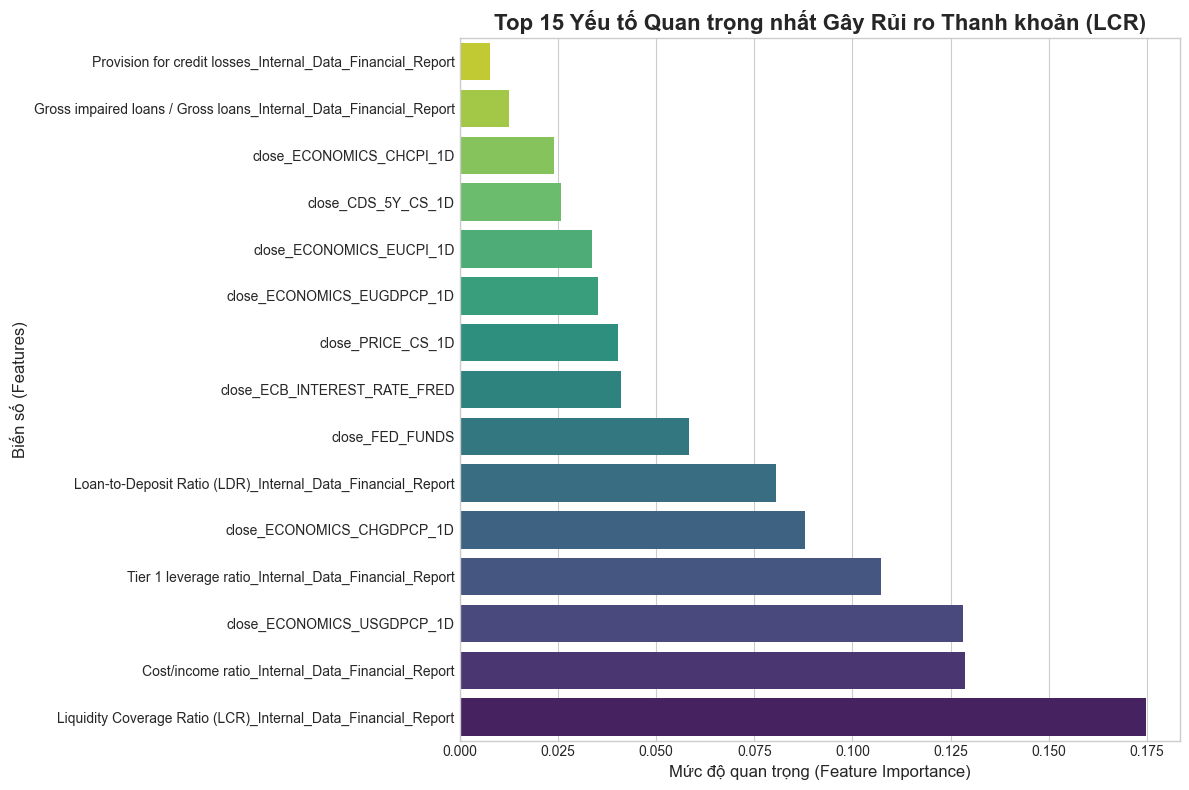


#### 4. Các yếu tố Gây **Rủi ro Vốn (CET1)**

Mô hình này chỉ ra rằng sức mạnh vốn của **Credit Suisse** liên quan chặt chẽ đến chất lượng tài sản và bối cảnh vĩ mô châu Âu.

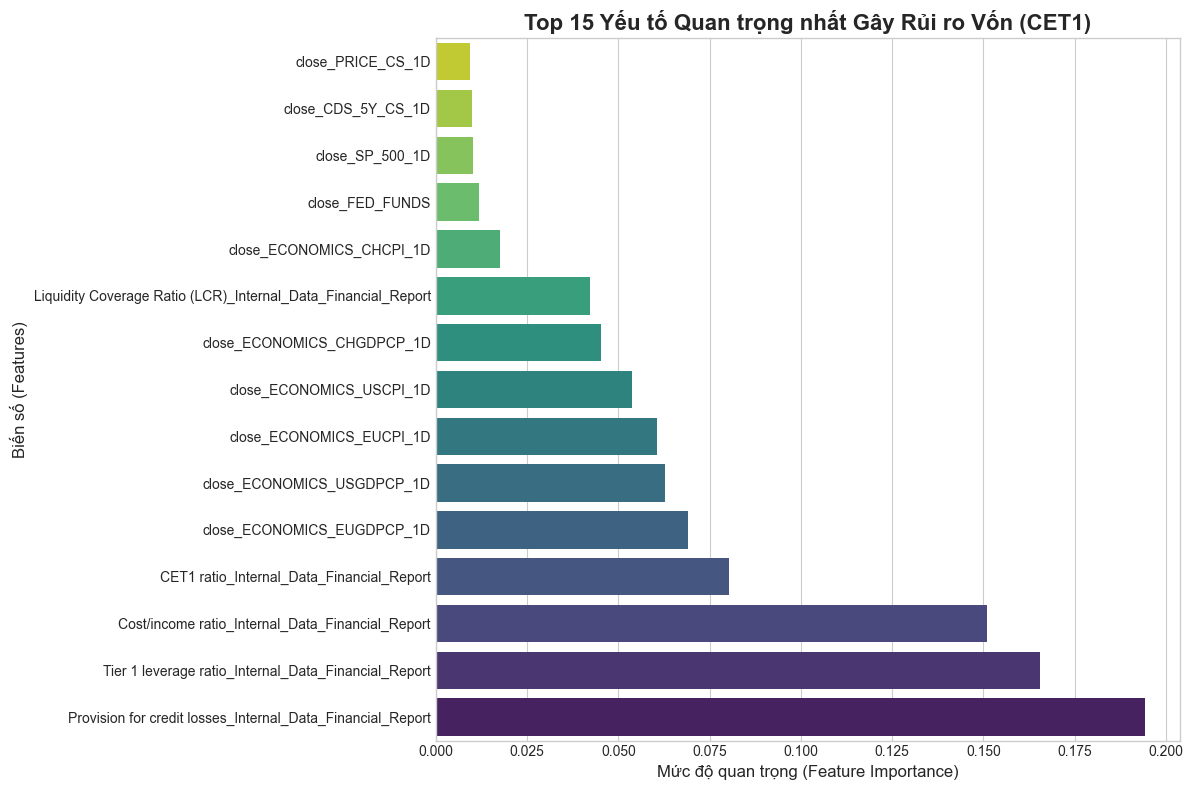

Top 5 yếu tố quan trọng nhất:
- **Chính chỉ số CET1**  
  → Tương tự LCR, quá khứ là yếu tố dự báo tốt nhất.

- **Chi phí dự phòng rủi ro tín dụng (Provision for credit losses)**  
  → Khi phải trích lập dự phòng nhiều, vốn chủ sở hữu bị ảnh hưởng trực tiếp.

- **Tỷ lệ đòn bẩy Cấp 1 (Tier 1 leverage ratio)**  
  → Xuất hiện lặp lại như yếu tố quan trọng.

- **GDP Liên minh Châu Âu (`close_ECONOMICS_EUGDPCP_1D`)**  
  → Tăng trưởng yếu làm tăng rủi ro cho các khoản vay.

- **CPI Liên minh Châu Âu (`close_ECONOMICS_EUCPI_1D`)**  
  → Lạm phát cao + thắt chặt tiền tệ gây áp lực cho bảng cân đối kế toán.

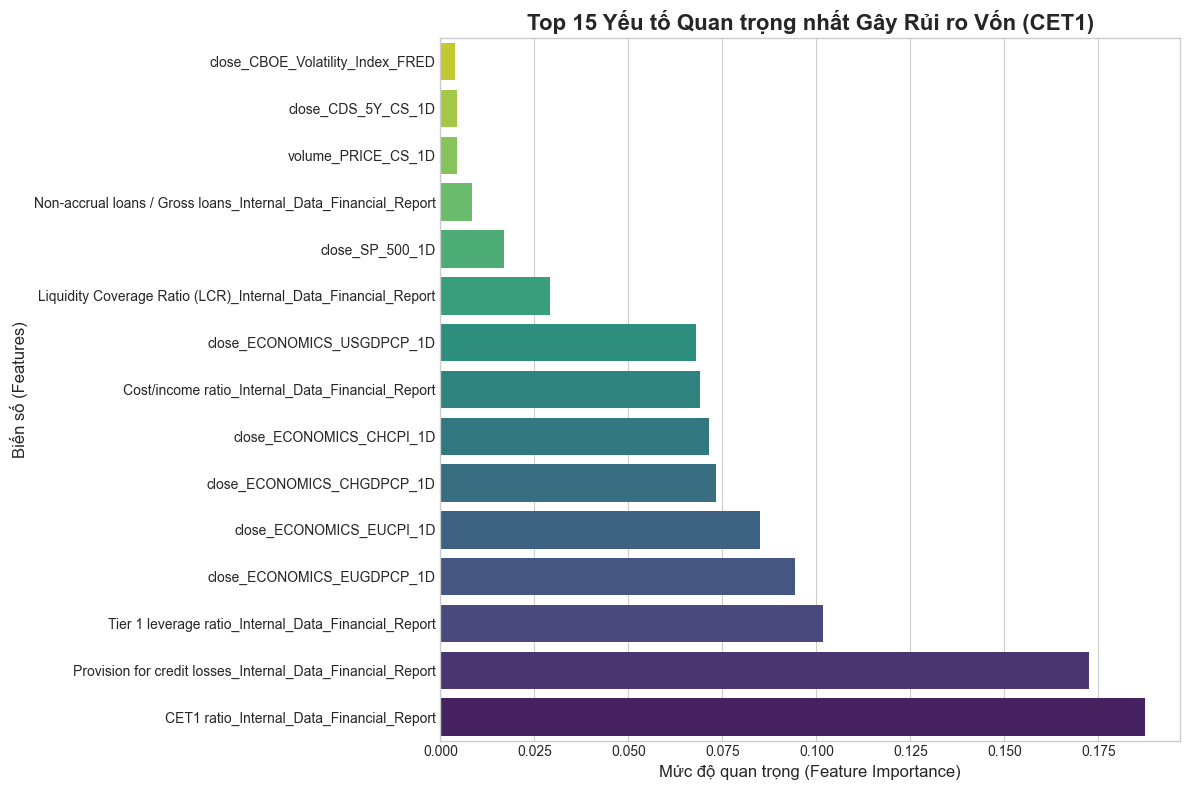


#### 5. Kết luận

Phân tích này mang lại kết quả rõ ràng: có hai nhóm yếu tố chính chi phối rủi ro của Credit Suisse:

1. **Rủi ro thị trường (Giá cổ phiếu, CDS)**  
   → Bị chi phối bởi các chỉ số thị trường có tần suất cao (VIX, chỉ số chứng khoán, khối lượng giao dịch).

2. **Rủi ro nội tại (LCR, CET1)**  
   → Phụ thuộc vào chỉ số tài chính (chi phí, dự phòng rủi ro) và yếu tố kinh tế vĩ mô (GDP, CPI) có chu kỳ dài hơn.

## 4. TỔNG KẾT

Nghiên cứu này đã xây dựng và đánh giá một khung phân tích định lượng đa mô hình nhằm đo lường và cảnh báo rủi ro cho ngân hàng Credit Suisse. Bằng cách tiếp cận bài toán theo hai hướng song song: Cảnh báo Dự báo và Phân tích Diễn giải, nhóm đã rút ra được những kết luận có giá trị và mang tính ứng dụng cao.

#### **1. Hướng tiếp cận Cảnh báo: Mô hình như một "Hệ thống Báo động Nhạy"**

Ban đầu, các thử nghiệm xây dựng mô hình để dự báo chính xác thời điểm khủng hoảng đã gặp thất bại. Nguyên nhân cốt lõi được xác định là do bản chất "cú sốc" đột ngột của cuộc khủng hoảng, khiến dữ liệu quá khứ không đủ để dự đoán tương lai một cách chính xác.

Tuy nhiên, thay vì loại bỏ hoàn toàn, nhóm đã tinh chỉnh và đánh giá lại mô hình dự báo dưới góc độ của một **hệ thống cảnh báo sớm**, nơi việc **không bỏ sót rủi ro (ưu tiên Recall)** được đặt lên hàng đầu. Kết quả cho thấy:

* Bằng cách hạ ngưỡng quyết định của mô hình LightGBM xuống 0.3, hệ thống đã có thể **phát hiện và cảnh báo đúng 84%** số ngày khủng hoảng thực sự đã xảy ra trong giai đoạn kiểm thử.
* Dù việc này đi kèm với một số lượng cảnh báo sai, nhưng nó đã chứng tỏ mô hình có thể hoạt động hiệu quả như một **công cụ sàng lọc cấp một**. Vai trò của nó không phải là đưa ra quyết định cuối cùng, mà là để tạo ra một danh sách các "ngày đáng ngờ" để các chuyên gia con người có thể tập trung phân tích sâu hơn.

=> **Kết luận:** Mô hình dự báo, dù không chính xác tuyệt đối, nhưng có giá trị thực tiễn cao khi được sử dụng như một hệ thống cảnh báo có độ nhạy cao, giúp giảm thiểu rủi ro bỏ sót các sự kiện nguy hiểm.

#### **2. Hướng tiếp cận Phân tích: "Đo lường" các Yếu tố Gây ra Khủng hoảng**

Để hiểu sâu hơn về "cơ chế" của cuộc khủng hoảng, nhóm đã chuyển hướng sang phân tích tầm quan trọng của các biến số (Feature Importance Analysis). Bằng cách huấn luyện các mô hình trên toàn bộ dữ liệu, nhóm đã "đo lường" thành công mức độ ảnh hưởng của từng yếu tố lên mỗi khía cạnh rủi ro.

* **Kết quả:** Phân tích đã chỉ ra các nhóm yếu tố ảnh hưởng rõ rệt:
    * **Rủi ro thị trường (Giá cổ phiếu, CDS):** Chịu ảnh hưởng lớn nhất từ các chỉ số tâm lý và biến động thị trường có tần suất cao như chỉ số VIX, khối lượng giao dịch, và diễn biến của các chỉ số chứng khoán lớn.
    * **Rủi ro nội tại (LCR, CET1):** Bị chi phối bởi các chỉ số trong chính báo cáo tài chính của ngân hàng (tỷ lệ chi phí/thu nhập, chi phí dự phòng rủi ro tín dụng) và các yếu tố kinh tế vĩ mô nền tảng (GDP, CPI).
    * **Việc đưa chỉ số đánh giá cảm xúc gây ra bởi các bài báo - `tatal mark` chưa cho thấy sự hiệu quả, điều này có thể diễn giải vì số lượng tin báo được thu thập quá ít, nên lượng ý nghĩa mang lại cho mô hình chưa đủ nhiều.**
    
=> **Kết luận:** Hướng tiếp cận này đã thành công trong việc xác định các "thủ phạm" và động lực chính đằng sau từng khía cạnh của cuộc khủng hoảng, cung cấp những hiểu biết sâu sắc và có giá trị cho việc giám sát rủi ro trong tương lai.

**Tóm lại**, nghiên cứu đã chứng minh rằng một khung phân tích đa mô hình có thể mang lại giá trị theo cả hai cách: vừa có thể được tinh chỉnh để hoạt động như một hệ thống cảnh báo sớm linh hoạt, vừa có thể được sử dụng như một công cụ phân tích mạnh mẽ để giải mã các cuộc khủng hoảng tài chính phức tạp.